In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os, json, hashlib, random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tensorflow.keras import layers, models, optimizers
from sklearn.metrics import classification_report, confusion_matrix

# 1. Ensure Reproducibility (Industry Requirement)
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
set_seeds()

# Path to your dataset (Ensure folders: cardboard, glass, metal, paper, plastic, trash)
DATASET_PATH = '/content/drive/MyDrive/AICTEinternship/TrashType_Image_Dataset'

In [4]:
def create_data_manifest(path, version="v1.0"):
    records = []
    print("🔍 Auditing dataset integrity...")
    for category in os.listdir(path):
        cat_path = os.path.join(path, category)
        if not os.path.isdir(cat_path): continue
        for img_name in os.listdir(cat_path):
            img_path = os.path.join(cat_path, img_name)
            try:
                with Image.open(img_path) as img:
                    img.verify() # Check if file is corrupt
                img_hash = hashlib.md5(open(img_path,'rb').read()).hexdigest()
                records.append({'hash': img_hash, 'label': category, 'path': img_path})
            except:
                print(f"🗑️ Removing corrupt file: {img_name}")
                os.remove(img_path)

    df = pd.DataFrame(records)
    df.to_csv(f'manifest_{version}.csv', index=False)
    return df

df_metadata = create_data_manifest(DATASET_PATH)

🔍 Auditing dataset integrity...


Found 2389 images belonging to 6 classes.
Found 594 images belonging to 6 classes.


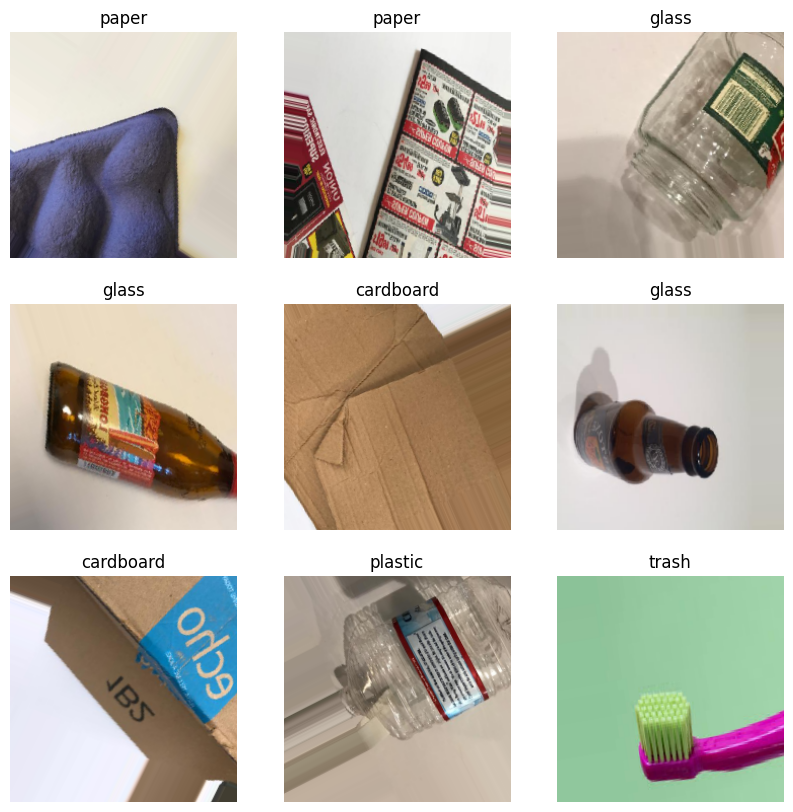

In [9]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Use official EfficientNet preprocessing
from tensorflow.keras.applications.efficientnet import preprocess_input

# Training Generator (with Augmentation)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Validation Generator (NO SHUFFLE for correct Evaluation)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_gen = train_datagen.flow_from_directory(
    DATASET_PATH, target_size=(224, 224), batch_size=32,
    class_mode='categorical', subset='training', seed=42
)

val_gen = val_datagen.flow_from_directory(
    DATASET_PATH, target_size=(224, 224), batch_size=32,
    class_mode='categorical', subset='validation',
    seed=42, shuffle=False  # <--- CRITICAL FIX: Set shuffle to False
)

# Visualize Batch
def show_augmented_batch(gen):
    imgs, labels = next(gen)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        # Note: preprocess_input makes images look weird in plt;
        # this is just for checking if objects are visible.
        plt.imshow(imgs[i].astype('uint8'))
        plt.title(list(gen.class_indices.keys())[np.argmax(labels[i])])
        plt.axis('off')
    plt.show()

show_augmented_batch(train_gen)

In [10]:
# Load Base Model
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False, weights='imagenet', input_shape=(224, 224, 3)
)
base_model.trainable = False

# Build Model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dense(train_gen.num_classes, activation='softmax')
])

# Compile with moderate LR for head training
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("🚀 Starting Warm-up Phase (Frozen Base)...")
history_warmup = model.fit(
    train_gen, validation_data=val_gen, epochs=10,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
🚀 Starting Warm-up Phase (Frozen Base)...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.6619 - loss: 0.9967 - val_accuracy: 0.7222 - val_loss: 0.7056
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 239s 3s/step - accuracy: 0.8585 - loss: 0.4102 - val_accuracy: 0.7626 - val_loss: 0.6005
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 236s 3s/step - accuracy: 0.8892 - loss: 0.3069 - val_accuracy: 0.8013 - val_loss: 0.5995
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 243s 3s/step - accuracy: 0.9090 - loss: 0.2524 - val_accuracy: 0.8232 - val_loss: 0.6086
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 241s 3s/step - accuracy: 0.9183 - loss: 0.2127 - val_accuracy: 0.8586 - val_loss: 0.5180
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 243s 3s/step - accuracy: 0.9220 - loss: 0.2082 - val_accuracy: 0.8451 - val_loss: 0.6058
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 244s 3s/step - accuracy: 0.9411 - loss: 0.1617 - val_accuracy: 0.8552 - val_loss: 0.5225
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 246s 3s/step - accuracy: 0.9447 - loss: 0.1470 - val_accuracy: 0.8535 - v

In [11]:
# Unfreeze the top 20 layers of the base
model.summary()
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Recompile with a VERY small learning rate
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("🚀 Starting Fine-Tuning Phase...")
history_fine = model.fit(
    train_gen, validation_data=val_gen, epochs=15,
    callbacks=[tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)]
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,048,247 (19.26 MB)

 Trainable params: 332,038 (1.27 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

 Optimizer params: 664,078 (2.53 MB)

🚀 Starting Fine-Tuning Phase...
Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 290s 4s/step - accuracy: 0.8753 - loss: 0.3687 - val_accuracy: 0.8485 - val_loss: 0.6226
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 274s 4s/step - accuracy: 0.8960 - loss: 0.3261 - val_accuracy: 0.8333 - val_loss: 0.6358
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 280s 4s/step - accuracy: 0.8840 - loss: 0.3157 - val_accuracy: 0.8249 - val_loss: 0.6471
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 272s 4s/step - accuracy: 0.9056 - loss: 0.2653 - val_accuracy: 0.8232 - val_loss: 0.6465
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 270s 4s/step - accuracy: 0.8974 - loss: 0.2808 - val_accuracy: 0.8300 - val_loss: 0.6422
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 266s 4s/step - accuracy: 0.9096 - loss: 0.2326 - val_accuracy: 0.8283 - val_loss: 0.6470
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 268s 4s/step - accuracy: 0.9223 - loss: 0.2432 - val_accuracy: 0.8367 - val_loss: 0.6448
Epoch 8/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 318s 4s/step - accuracy: 0.9064 - loss: 0

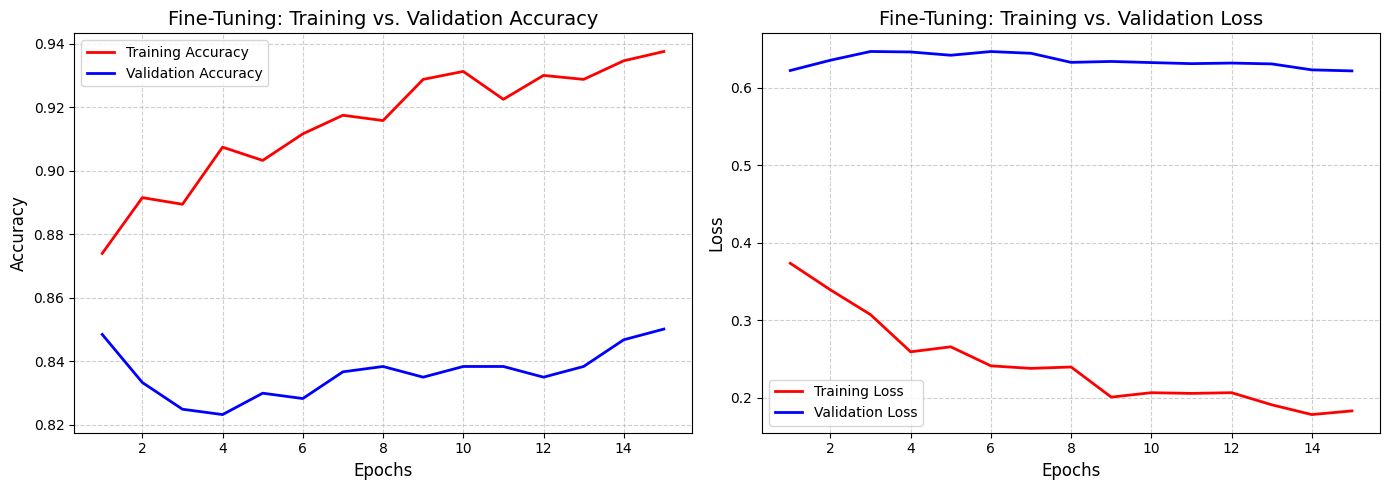

In [12]:
import matplotlib.pyplot as plt

# 1. Extract metrics from the history object
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']
loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']
epochs = range(1, len(acc) + 1)

# 2. Create a professional side-by-side plot
plt.figure(figsize=(14, 5))

# --- Plot 1: Accuracy ---
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r-', label='Training Accuracy', linewidth=2)
plt.plot(epochs, val_acc, 'b-', label='Validation Accuracy', linewidth=2)
plt.title('Fine-Tuning: Training vs. Validation Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# --- Plot 2: Loss ---
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training Loss', linewidth=2)
plt.plot(epochs, val_loss, 'b-', label='Validation Loss', linewidth=2)
plt.title('Fine-Tuning: Training vs. Validation Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step
--- Classification Report ---
              precision    recall  f1-score   support

   cardboard       0.95      0.93      0.94        80
       glass       0.89      0.95      0.92       100
       metal       0.79      0.96      0.87        82
       paper       0.77      0.87      0.82       118
     plastic       0.94      0.76      0.84        96
       trash       0.84      0.69      0.75       118

    accuracy                           0.85       594
   macro avg       0.86      0.86      0.86       594
weighted avg       0.86      0.85      0.85       594



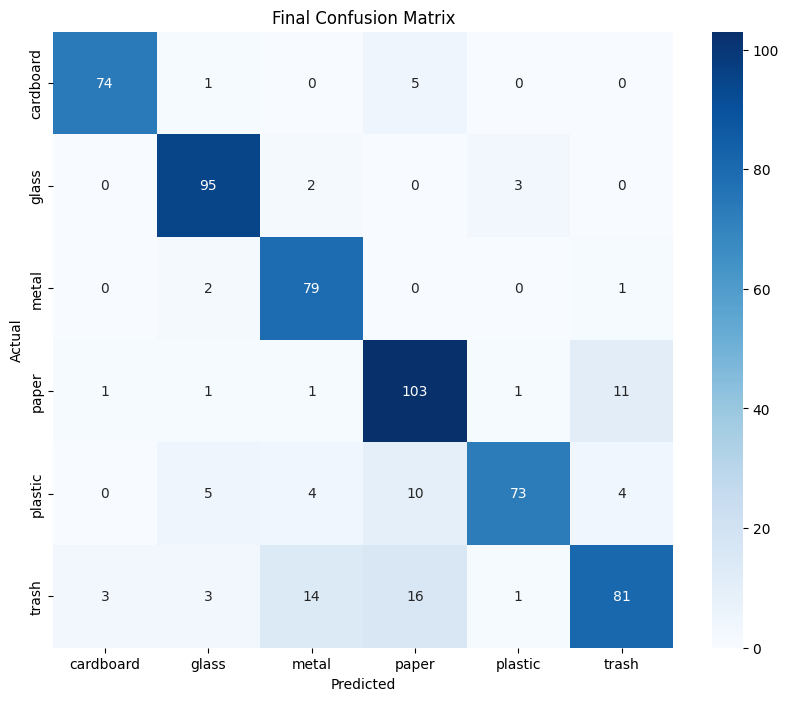

In [18]:
# 1. Reset generator to the start
#val_gen.reset()

# 2. Get predictions
Y_pred = model.predict(val_gen)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

# 3. Classification Report
print("--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=class_labels))

# 4. Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Final Confusion Matrix')
plt.show()

In [19]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

# 1. Get the raw predictions
Y_pred = model.predict(val_gen)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_gen.classes

# 2. Calculate raw Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# 3. Calculate and Print Accuracy
final_acc = np.trace(cm) / np.sum(cm)
print(f"--- FINAL MODEL ANALYSIS ---")
print(f"Total Images Evaluated: {np.sum(cm)}")
print(f"Correct Predictions:    {np.trace(cm)}")
print(f"Overall Accuracy:       {final_acc * 100:.2f}%")

# 4. (Optional) Print accuracy for each specific class
class_labels = list(val_gen.class_indices.keys())
for i, label in enumerate(class_labels):
    class_acc = cm[i,i] / np.sum(cm[i,:])
    print(f"Accuracy for {label:10}: {class_acc * 100:.2f}%")

19/19 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step
--- FINAL MODEL ANALYSIS ---
Total Images Evaluated: 594
Correct Predictions:    505
Overall Accuracy:       85.02%
Accuracy for cardboard : 92.50%
Accuracy for glass     : 95.00%
Accuracy for metal     : 96.34%
Accuracy for paper     : 87.29%
Accuracy for plastic   : 76.04%
Accuracy for trash     : 68.64%


In [20]:
# Evaluate the model on the test generator
results = model.evaluate(val_gen)
print(f"\nTest Loss: {results[0]:.4f}")
print(f"Final Test Accuracy: {results[1]*100:.2f}%")

19/19 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.9113 - loss: 0.3512

Test Loss: 0.6221
Final Test Accuracy: 85.02%


📤 Please upload your garbage image:


Saving IMG_20260203_151059_099.jpg to IMG_20260203_151059_099.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


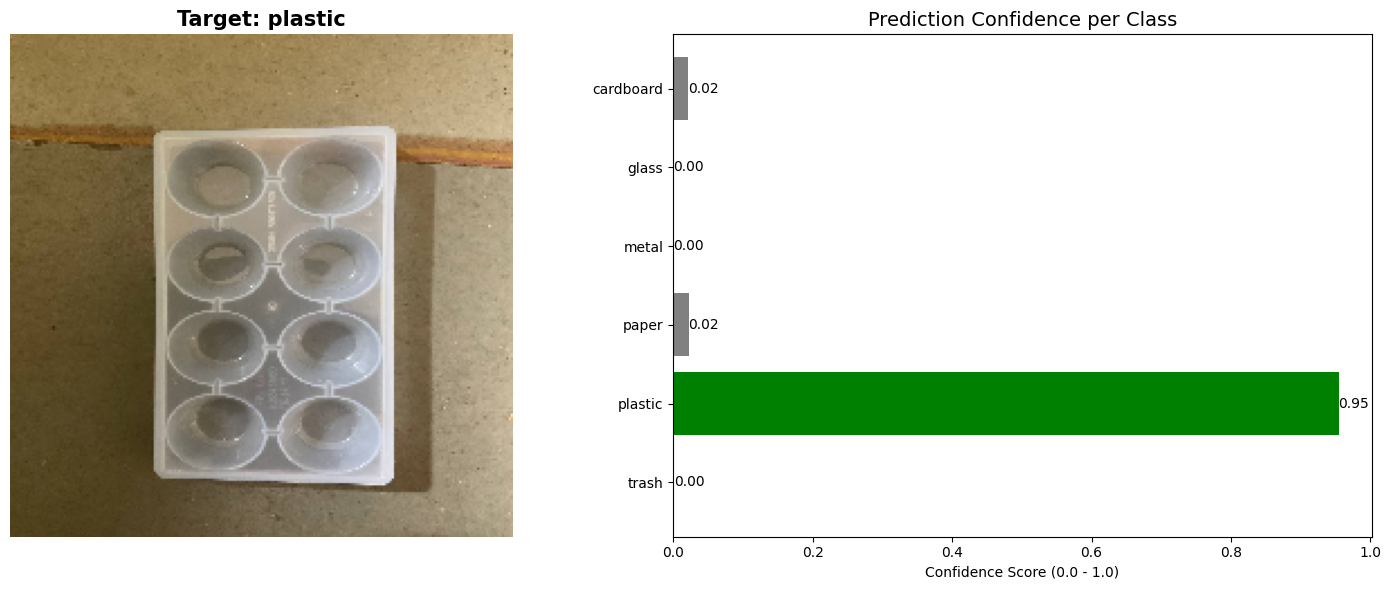

In [23]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
import matplotlib.pyplot as plt

def test_with_confidence_bar(model, class_indices):
    print("📤 Please upload your garbage image:")
    uploaded = files.upload()

    class_names = list(class_indices.keys())

    for fn in uploaded.keys():
        # 1. Image Preprocessing
        img = image.load_img(fn, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_batch = np.expand_dims(img_array, axis=0)
        img_preprocessed = preprocess_input(img_batch)

        # 2. Get Raw Predictions (Probabilities)
        predictions = model.predict(img_preprocessed)[0]
        predicted_class_idx = np.argmax(predictions)
        predicted_class = class_names[predicted_class_idx]

        # 3. Create Visualization Layout
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Left Side: The Image
        ax1.imshow(img)
        ax1.set_title(f"Target: {predicted_class}", fontsize=15, fontweight='bold')
        ax1.axis('off')

        # Right Side: The Confidence Bar Graph
        y_pos = np.arange(len(class_names))
        colors = ['gray'] * len(class_names)
        colors[predicted_class_idx] = 'green' # Highlight the top prediction in green

        bars = ax2.barh(y_pos, predictions, align='center', color=colors)
        ax2.set_yticks(y_pos)
        ax2.set_yticklabels(class_names)
        ax2.invert_yaxis()  # Labels read top-to-bottom
        ax2.set_xlabel('Confidence Score (0.0 - 1.0)')
        ax2.set_title('Prediction Confidence per Class', fontsize=14)

        # Add text labels on bars
        for bar in bars:
            width = bar.get_width()
            ax2.text(width, bar.get_y() + bar.get_height()/2,
                     f'{width:.2f}', va='center', fontsize=10)

        plt.tight_layout()
        plt.show()

# --- EXECUTE ---
test_with_confidence_bar(model, train_gen.class_indices)

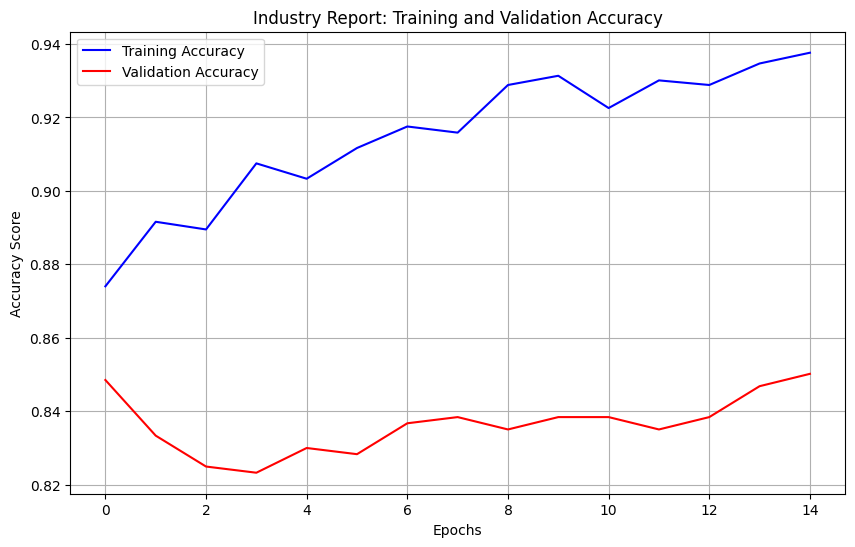

In [24]:
def plot_final_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(acc))

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Industry Report: Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy Score')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_final_results(history_fine)

In [28]:
# 1. Final Save
model.save("garbage_classifier_final.keras")

# 2. Load the 'best' version saved by the ModelCheckpoint callback
checkpoint_path = 'best_model.keras'

if os.path.exists(checkpoint_path):
    final_model = tf.keras.models.load_model(checkpoint_path)
    print("✅ Loaded the absolute best weights from Checkpoint.")
else:
    final_model = model
    print("⚠️ Checkpoint not found, using the weights from the last epoch.")

# 3. Export and Download
export_filename = 'garbage_classifier_efficientnetb0_model.keras'
final_model.save(export_filename)

from google.colab import files
files.download(export_filename)

print(f"✅ {export_filename} saved and download triggered!")

✅ Loaded the absolute best weights from Checkpoint.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ garbage_classifier_efficientnetb0_model.keras saved and download triggered!
